### Import th∆∞ vi·ªán

In [2]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout  # type: ignore
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

/Users/phongtran/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### T·∫°o d·ªØ li·ªáu gi·∫£

In [3]:
# Number of samples
n_samples = 1000000

# Initial pH value
current_pH = np.random.uniform(6.5, 7.5)  # Start within the safe range
pH_values = []

# Safe range and limits
safe_lower = 6.5
safe_upper = 7.5
absolute_lower = 1.0
absolute_upper = 10.0

# Generate pH values
for _ in range(n_samples):
    # Randomly increase or decrease by 0.1
    current_pH += np.random.choice([-0.1, 0.1])

    # Check limits
    if current_pH < absolute_lower or current_pH > absolute_upper:
        current_pH = np.clip(current_pH, absolute_lower, absolute_upper)

    # Handle safe range violations
    if current_pH < safe_lower or current_pH > safe_upper:
        if np.random.random() < 0.9:  # 90% chance to move back towards the safe range
            if current_pH < safe_lower:
                current_pH += 0.01
            elif current_pH > safe_upper:
                current_pH -= 0.01

    # Ensure pH remains within absolute limits
    current_pH = np.clip(current_pH, absolute_lower, absolute_upper)
    pH_values.append(current_pH)

# Generate DO (Dissolved Oxygen) values (similar random fluctuations)
DO_values = []
current_DO = np.random.uniform(3.0, 7.0)
for _ in range(n_samples):
    current_DO += np.random.uniform(-0.2, 0.2)
    current_DO = np.clip(current_DO, 0.0, 10.0)
    DO_values.append(current_DO)

# Calculate pump time
water_volume = 1000  # Fixed water volume in liters
pump_flow_rate = 10  # Flow rate in liters per second
adjustment_factor = 0.5
pump_times = []

for pH in pH_values:
    if pH < safe_lower:
        time = adjustment_factor * \
            (safe_lower - pH) * water_volume / pump_flow_rate
    elif pH > safe_upper:
        time = adjustment_factor * \
            (pH - safe_upper) * water_volume / pump_flow_rate
    else:
        time = 0
    pump_times.append(time)

# Create a DataFrame
data = {
    "pH": pH_values,
    "DO": DO_values,
    "Pump Time (s)": pump_times
}
df = pd.DataFrame(data)

# Save to CSV
file_path = "./simulated_pH_data.csv"
df.to_csv(file_path, index=False)

file_path

'./simulated_pH_data.csv'

### Ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu

D·ªØ li·ªáu kh√¥ng c√≥ gi√° tr·ªã b·ªã thi·∫øu.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   pH      1000000 non-null  float64
dtypes: float64(1)
memory usage: 7.6 MB
None
                   pH
count  1000000.000000
mean         0.500411
std          0.174018
min          0.000000
25%          0.386005
50%          0.498871
75%          0.611738
max          1.000000


Text(0.5, 0, 'Th·ªùi gian')

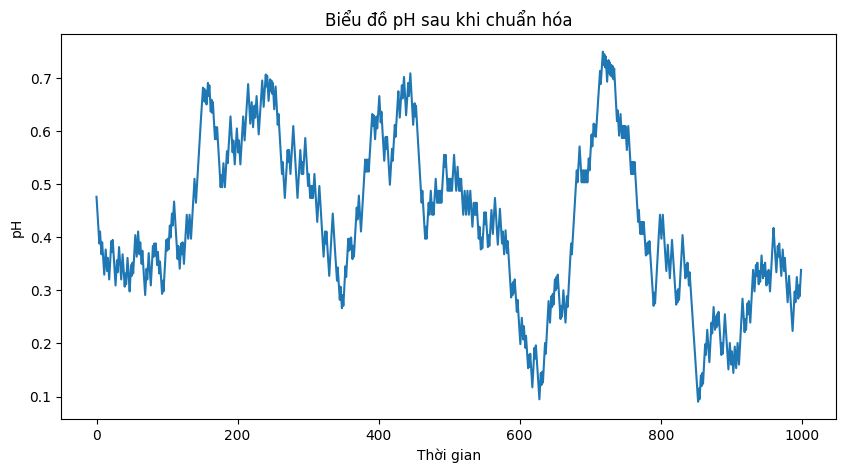

In [4]:
from sklearn.preprocessing import MinMaxScaler
# path = "/Users/phongtran/Downloads/simulated_pH_data.csv"
path = "./simulated_pH_data.csv"

# C·∫•u h√¨nh
cols = ['pH']
df = pd.read_csv(path)

# Ch·ªâ l·∫•y c√°c c·ªôt c·∫ßn thi·∫øt
df = df[cols]

# X·ª≠ l√Ω gi√° tr·ªã b·∫•t th∆∞·ªùng (outliers)
for col in cols:
    outliers = df[(df[col] < df[col].quantile(0.01)) |
                  (df[col] > df[col].quantile(0.99))]
    if len(outliers) > 0:
        df[col] = np.where(
            (df[col] < df[col].quantile(0.01)) | (
                df[col] > df[col].quantile(0.99)),
            df[col].median(),
            df[col]
        )

# X·ª≠ l√Ω gi√° tr·ªã thi·∫øu (NaN)
if df.isnull().sum().sum() > 0:
    print("D·ªØ li·ªáu c√≥ gi√° tr·ªã b·ªã thi·∫øu. Ti·∫øn h√†nh x·ª≠ l√Ω...")
    df = df.fillna(df.mean())  # S·ª≠a l·ªói inplace=True
else:
    print("D·ªØ li·ªáu kh√¥ng c√≥ gi√° tr·ªã b·ªã thi·∫øu.")

# Chu·∫©n h√≥a d·ªØ li·ªáu b·∫±ng MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)  # Scale ch·ªâ c√°c c·ªôt s·ªë, kh√¥ng c√≥ Date

# Chuy·ªÉn k·∫øt qu·∫£ v·ªÅ DataFrame v√† gi·ªØ nguy√™n t√™n c·ªôt
scaled_df = pd.DataFrame(scaled_data, columns=cols)

# Ki·ªÉm tra th√¥ng tin d·ªØ li·ªáu
print(scaled_df.info())  # Ki·ªÉm tra ki·ªÉu d·ªØ li·ªáu v√† gi√° tr·ªã null
print(scaled_df.describe())

# V·∫Ω bi·ªÉu ƒë·ªì ki·ªÉm tra d·ªØ li·ªáu
plt.figure(figsize=(10, 5))
sns.lineplot(scaled_df['pH'][0:1000])
plt.title("Bi·ªÉu ƒë·ªì pH sau khi chu·∫©n h√≥a")
plt.xlabel("Th·ªùi gian")

### T·∫°o chu·ªói d·ªØ li·ªáu v√† chia t·∫≠p d·ªØ li·ªáu hu·∫•n luy·ªán

In [5]:
def create_sequences(data, look_back=30):
    """
    T·∫°o chu·ªói th·ªùi gian cho m√¥ h√¨nh.
    - data: D·ªØ li·ªáu ƒë√£ chu·∫©n h√≥a (numpy array).
    - look_back: S·ªë b∆∞·ªõc th·ªùi gian tr∆∞·ªõc ƒë√≥ ƒë·ªÉ l√†m ƒë·∫ßu v√†o.
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])  # T·∫•t c·∫£ c·ªôt
        y.append(data[i + look_back, 0])  # c·ªôt d·∫ßu ti√™n
    return np.array(X), np.array(y)


# Chia d·ªØ li·ªáu th√†nh t·∫≠p train/test
train_size = int(len(scaled_data) * 0.8)  # 80% cho train, 20% cho test
train, test = scaled_data[:train_size], scaled_data[train_size:]

# T·∫°o chu·ªói d·ªØ li·ªáu
look_back = 20  # ƒê·ªô d√†i chu·ªói
X_train, y_train = create_sequences(train, look_back)
X_test, y_test = create_sequences(test, look_back)

# ƒê·ªãnh h√¨nh l·∫°i input cho CNN-LSTM: [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

print("Shape c·ªßa X_train:", X_train.shape)
print("Shape c·ªßa y_train:", y_train.shape)
print("Shape c·ªßa X_test:", X_test.shape)
print("Shape c·ªßa y_test:", y_test.shape)


# Ki·ªÉm tra NaN sau khi x·ª≠ l√Ω
print("Ki·ªÉm tra gi√° tr·ªã NaN trong d·ªØ li·ªáu ƒë√£ x·ª≠ l√Ω...")
if np.isnan(X_train).sum() > 0 or np.isnan(X_test).sum() > 0:
    print("C√≥ gi√° tr·ªã NaN trong d·ªØ li·ªáu sau khi x·ª≠ l√Ω.")
else:
    print("Kh√¥ng c√≥ gi√° tr·ªã NaN trong d·ªØ li·ªáu. D·ªØ li·ªáu ƒë√£ s·∫°ch.")

Shape c·ªßa X_train: (799980, 20, 1)
Shape c·ªßa y_train: (799980,)
Shape c·ªßa X_test: (199980, 20, 1)
Shape c·ªßa y_test: (199980,)
Ki·ªÉm tra gi√° tr·ªã NaN trong d·ªØ li·ªáu ƒë√£ x·ª≠ l√Ω...
Kh√¥ng c√≥ gi√° tr·ªã NaN trong d·ªØ li·ªáu. D·ªØ li·ªáu ƒë√£ s·∫°ch.


### X√¢y d·ª±ng m√¥ h√¨nh

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


# X√¢y d·ª±ng m√¥ h√¨nh
model = Sequential()

# L·ªõp CNN
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
          input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# L·ªõp LSTM
model.add(LSTM(100, return_sequences=True))  # Tr·∫£ v·ªÅ chu·ªói ƒë·∫ßu ra
model.add(Dropout(0.3))
# L·ªõp LSTM cu·ªëi kh√¥ng c·∫ßn tr·∫£ v·ªÅ chu·ªói
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.3))

# Dense Layer
model.add(Dense(50, activation='relu'))
model.add(Dense(1))  # ƒê·∫ßu ra 1 gi√° tr·ªã pH

# Compile m√¥ h√¨nh
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(model.summary())
model.save('test-3.h5')

/Users/phongtran/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv1d (Conv1D)                 ‚îÇ (None, 18, 64)         ‚îÇ           256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling1d (MaxPooling1D)    ‚îÇ (None, 9, 64)          ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 9, 64)          ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm (LSTM)                     ‚îÇ (None, 9, 100)         ‚îÇ        66,000 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 9, 100)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_1 (LSTM)                   ‚îÇ (None, 50)             ‚îÇ        30,200 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)             ‚îÇ (None, 50)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 50)             ‚îÇ         2,550 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 1)              ‚îÇ            51 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 99,057 (386.94 KB)

 Trainable params: 99,057 (386.94 KB)

 Non-trainable params: 0 (0.00 B)

None


### Hu·∫•n luy·ªán m√¥ h√¨nh v·ªõi lr ƒë·ªông

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Callback ƒë·ªÉ t·ª± ƒë·ªông l∆∞u m√¥ h√¨nh t·ªët nh·∫•t
checkpoint = ModelCheckpoint(
    'best_model.h5',  # T√™n t·ªáp l∆∞u
    monitor='val_loss',  # Theo d√µi validation loss
    save_best_only=True,  # Ch·ªâ l∆∞u khi val_loss gi·∫£m
    mode='min'
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Theo d√µi validation loss
    factor=0.5,          # Gi·∫£m learning rate ƒëi 50%
    patience=4,          # N·∫øu val_loss kh√¥ng gi·∫£m trong 5 epochs th√¨ gi·∫£m lr
    min_lr=1e-6          # Kh√¥ng gi·∫£m lr xu·ªëng th·∫•p h∆°n 0.000001
)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, checkpoint],  # Th√™m ReduceLROnPlateau v√†o callback
    verbose=1
)

Epoch 1/10
24999/25000 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 0.0019 - mae: 0.0299

25000/25000 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 227s 9ms/step - loss: 0.0019 - mae: 0.0299 - val_loss: 0.0067 - val_mae: 0.0682 - learning_rate: 0.0010
Epoch 2/10
25000/25000 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 202s 8ms/step - loss: 0.0017 - mae: 0.0277 - val_loss: 0.0073 - val_mae: 0.0696 - learning_rate: 0.0010
Epoch 3/10
25000/25000 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 223s 9ms/step - loss: 0.0016 - mae: 0.0271 - val_loss: 0.0081 - val_mae: 0.0754 - learning_rate: 0.0010
Epoch 4/10
25000/25000 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 232s 9ms/step - loss: 0.0016 - mae: 0.0267 - val_loss: 0.0084 - val_mae: 0.0756 - learning_rate: 0.0010
Epoch 5/10
25000/25000 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 232s 9ms/step - loss: 0.0015 - mae: 0.0263 - val_loss: 0.0078 - val_mae: 0.0729 - learning_rate: 0.0010
Epoch 6/10
25000/25000 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

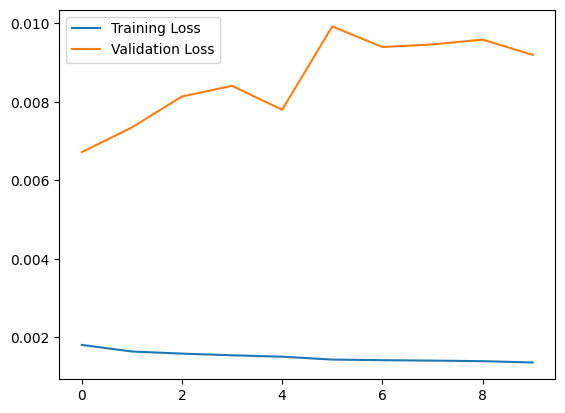

In [9]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

### Ki·ªÉm tra m√¥ h√¨nh

6250/6250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 2ms/step
(199980,)


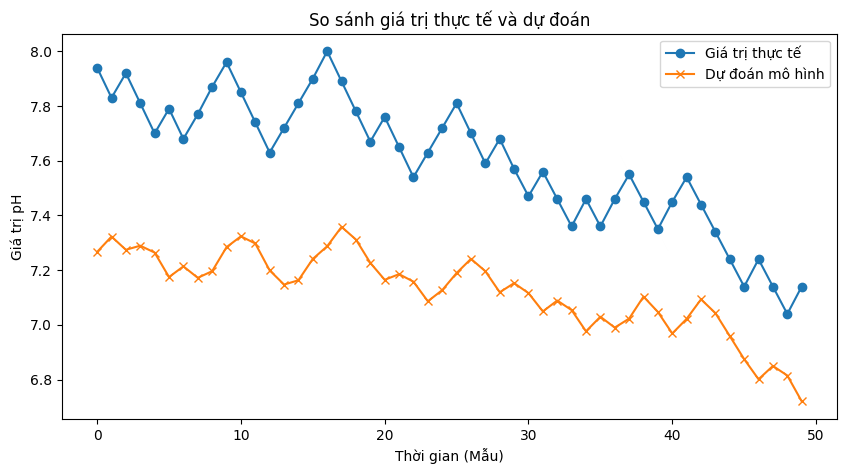

üîπ MAE (Mean Absolute Error): 0.3548
üîπ MSE (Mean Squared Error): 0.1805


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


# D·ª± ƒëo√°n tr√™n t·∫≠p Validation
y_pred_val = model.predict(X_test)
print(y_test.shape)
# Chuy·ªÉn ƒë·ªïi d·ªØ li·ªáu tr·ªü l·∫°i thang ƒëo ban ƒë·∫ßu (n·∫øu ƒë√£ chu·∫©n h√≥a)
y_val_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_val_original = scaler.inverse_transform(y_pred_val)


# Ch·ªçn m·ªôt s·ªë l∆∞·ª£ng nh·ªè ƒëi·ªÉm ƒë·ªÉ v·∫Ω (v√≠ d·ª•: 50 ƒëi·ªÉm ƒë·∫ßu ti√™n)
num_samples = 50

plt.figure(figsize=(10, 5))
plt.plot(y_val_original[:num_samples], label='Gi√° tr·ªã th·ª±c t·∫ø', marker='o')
plt.plot(y_pred_val_original[:num_samples],
         label='D·ª± ƒëo√°n m√¥ h√¨nh', marker='x')

plt.title("So s√°nh gi√° tr·ªã th·ª±c t·∫ø v√† d·ª± ƒëo√°n")
plt.xlabel("Th·ªùi gian (M·∫´u)")
plt.ylabel("Gi√° tr·ªã pH")
plt.legend()
plt.show()


mae = mean_absolute_error(y_val_original, y_pred_val_original)
mse = mean_squared_error(y_val_original, y_pred_val_original)

print(f"üîπ MAE (Mean Absolute Error): {mae:.4f}")
print(f"üîπ MSE (Mean Squared Error): {mse:.4f}")
# # Sai s·ªë tuy·ªát ƒë·ªëi
# errors = np.abs(y_test - y_pred_val)

# # T√≠nh ph·∫ßn trƒÉm m·∫´u c√≥ sai s·ªë <= 0.1
# accuracy = np.sum(errors <= 0.1) / len(errors) * 100

# print(f"T·ª∑ l·ªá m·∫´u c√≥ sai s·ªë <= 0.1: {accuracy:.2f}%")

### Th·ª±c hi·ªán d·ª± ƒëo√°n

In [2]:

# Sao ch√©p chu·ªói d·ªØ li·ªáu cu·ªëi c√πng t·ª´ t·∫≠p validation
future_sequence = X_test[-1].copy().reshape(1,
                                            # L·∫•y m·∫´u cu·ªëi c√πng
                                            X_test.shape[1], X_test.shape[2])

# Danh s√°ch l∆∞u k·∫øt qu·∫£ d·ª± ƒëo√°n
future_predictions = []

# D·ª± ƒëo√°n 10 b∆∞·ªõc ti·∫øp theo
num_future_steps = 10

for _ in range(num_future_steps):
    # D·ª± ƒëo√°n b∆∞·ªõc ti·∫øp theo
    next_pred = model.predict(future_sequence)

    # L∆∞u gi√° tr·ªã d·ª± ƒëo√°n
    future_predictions.append(next_pred[0, 0])  # Ch·ªâ l·∫•y gi√° tr·ªã scalar

    # C·∫≠p nh·∫≠t chu·ªói d·ªØ li·ªáu: b·ªè ƒëi·ªÉm ƒë·∫ßu, th√™m gi√° tr·ªã m·ªõi v√†o cu·ªëi
    # D·ªãch d·ªØ li·ªáu sang tr√°i
    future_sequence = np.roll(future_sequence, shift=-1, axis=1)
    future_sequence[0, -1, 0] = next_pred  # Th√™m gi√° tr·ªã m·ªõi v√†o cu·ªëi chu·ªói

# Chuy·ªÉn k·∫øt qu·∫£ d·ª± ƒëo√°n v·ªÅ thang ƒëo g·ªëc n·∫øu d·ªØ li·ªáu ƒë√£ ƒë∆∞·ª£c chu·∫©n h√≥a
future_predictions_original = scaler.inverse_transform(
    np.array(future_predictions).reshape(-1, 1))

# Hi·ªÉn th·ªã k·∫øt qu·∫£ d·ª± ƒëo√°n
print("üîÆ D·ª± ƒëo√°n 10 gi√° tr·ªã ti·∫øp theo:")
print(future_predictions_original)
sns.lineplot(future_predictions_original)

NameError: name 'X_test' is not defined